# Image Classification with Logistic Regression

In [3]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T

from torch.utils.data import random_split
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

%matplotlib inline

## Dataset & Data loaders

In [4]:
# Download dataset
dataset = torchvision.datasets.CIFAR10(root='data', train=True, transform=T.ToTensor(), download=True)
test_ds = torchvision.datasets.CIFAR10(root='data', train=False, transform=T.ToTensor(), download=True)

len(dataset), len(test_ds)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [5]:
classes = list(dataset.classes)
num_classes = len(classes)

classes, num_classes

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 10)

In [6]:
# Training, validation & test dataset
val_ds_size = 5000
train_ds_size = len(dataset) - val_ds_size

random_seed = 42
torch.manual_seed(random_seed)
train_ds, val_ds = random_split(dataset, [train_ds_size, val_ds_size])

len(train_ds), len(val_ds)

(45000, 5000)

In [7]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 32*32
num_classes = 10

# Dataloaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size*2)
test_dl = DataLoader(test_ds, batch_size*2)

Label: 6


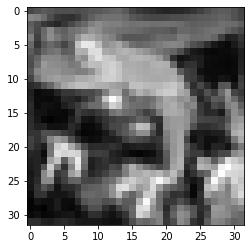

In [26]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [27]:
image.shape

torch.Size([3, 32, 32])

## Load to GPU

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [40]:
for b in train_dl:
    x, y = b
    x.shape
    break

## Model

In [11]:
class Cifar10LRModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3*32*32, 10)
        
    def forward(self, batch):
        batch = batch.reshape(-1, 3*32*32)
        out = self.linear(batch)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    


In [12]:
model = Cifar10LRModel()
to_device(model, device)

Cifar10LRModel(
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

## Training

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [77]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(model, train_loader, val_loader, epochs, lr, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [64]:
evaluate(model, val_dl)

{'val_loss': 1.8633081912994385, 'val_acc': 0.3997817039489746}

In [48]:
def get_plot(history, i=0):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    if i:
        plt.title(f"Result of Run [{i}]")
    else:
        plt.title("Result of Session")

    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    ax1.plot(train_losses, '-cx', alpha=0.5)
    ax1.plot(val_losses, '-x', alpha=0.5)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])

    ax2 = ax1.twinx()
    accuracies = [x['val_acc'] for x in history]
    ax2.plot(accuracies, marker='o', color='r')
    ax2.set_ylabel('accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    plt.show()

In [78]:
def run(i):
    history = fit(model, train_dl, val_dl, epochs, lr, opt_func)
    session.extend(history)
    runs['run #'].append(i)
    runs['num_epochs'].append(epochs)
    runs['opt_func'].append(opt_func.__name__)
    runs['learing_rate'].append(lr)
    runs['last_acc'].append(history[-1]['val_acc'])
    get_plot(history, i)
    history = []

In [74]:
# Session init

session = []

runs = {
    'run #': [],
    'num_epochs': [],
    'opt_func': [],
    'learing_rate': [],
    'last_acc': []
}

Epoch [0], val_loss: 1.7638, val_acc: 0.4066
Epoch [1], val_loss: 1.7637, val_acc: 0.4052
Epoch [2], val_loss: 1.7635, val_acc: 0.4058
Epoch [3], val_loss: 1.7635, val_acc: 0.4054
Epoch [4], val_loss: 1.7632, val_acc: 0.4053
Epoch [5], val_loss: 1.7631, val_acc: 0.4062
Epoch [6], val_loss: 1.7631, val_acc: 0.4062
Epoch [7], val_loss: 1.7630, val_acc: 0.4060
Epoch [8], val_loss: 1.7629, val_acc: 0.4055
Epoch [9], val_loss: 1.7627, val_acc: 0.4070


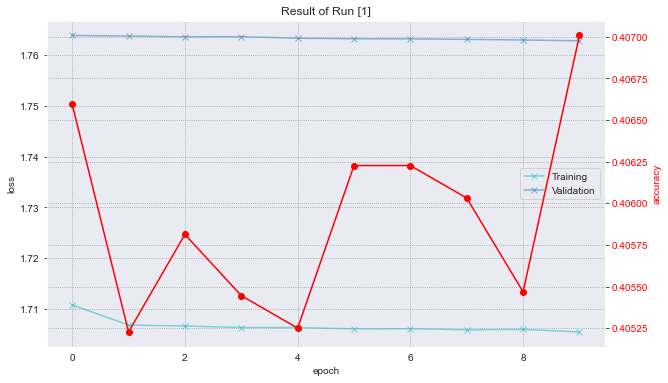

In [84]:
epochs = 10
lr = 0.0001
opt_func = torch.optim.SGD
run(1)

Epoch [0], val_loss: 1.7626, val_acc: 0.4044
Epoch [1], val_loss: 1.7610, val_acc: 0.4061
Epoch [2], val_loss: 1.7628, val_acc: 0.4047
Epoch [3], val_loss: 1.7582, val_acc: 0.4061
Epoch [4], val_loss: 1.7582, val_acc: 0.4053
Epoch [5], val_loss: 1.7573, val_acc: 0.4078
Epoch [6], val_loss: 1.7564, val_acc: 0.4068
Epoch [7], val_loss: 1.7555, val_acc: 0.4084
Epoch [8], val_loss: 1.7538, val_acc: 0.4074
Epoch [9], val_loss: 1.7535, val_acc: 0.4078


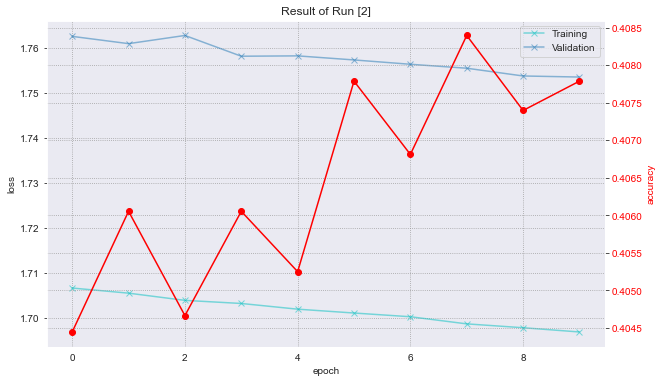

In [85]:
epochs = 10
lr = 0.001
opt_func = torch.optim.SGD
run(2)

Epoch [0], val_loss: 1.7771, val_acc: 0.3907
Epoch [1], val_loss: 1.7671, val_acc: 0.3982
Epoch [2], val_loss: 1.7460, val_acc: 0.4067
Epoch [3], val_loss: 1.7681, val_acc: 0.3857
Epoch [4], val_loss: 1.7561, val_acc: 0.3982
Epoch [5], val_loss: 1.7404, val_acc: 0.4017
Epoch [6], val_loss: 1.7614, val_acc: 0.3959
Epoch [7], val_loss: 1.7524, val_acc: 0.3952
Epoch [8], val_loss: 1.7294, val_acc: 0.4033
Epoch [9], val_loss: 1.7374, val_acc: 0.3988


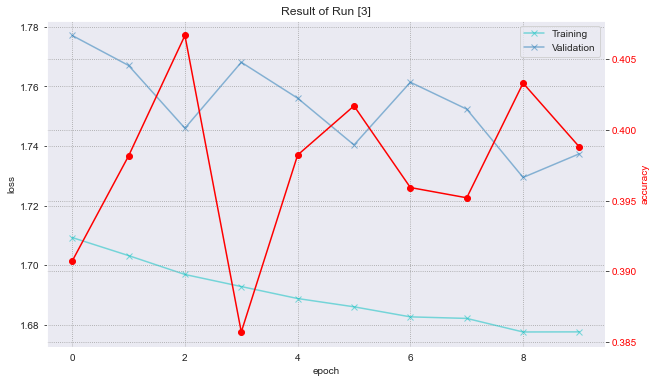

In [86]:
epochs = 10
lr = 0.01
opt_func = torch.optim.SGD
run(3)

In [25]:
import pandas as pd

In [82]:
def session_result():
    runs_df = pd.DataFrame(runs)
    print(runs_df.to_string(index=False))
    get_plot(session)


 run #  num_epochs opt_func  learing_rate  last_acc
     1           3      SGD        0.0001  0.403493
     2           3      SGD        0.0010  0.403711
     3           3      SGD        0.0100  0.408352
     1          10      SGD        0.0001  0.407008
     2          10      SGD        0.0010  0.407790
     3          10      SGD        0.0100  0.398782


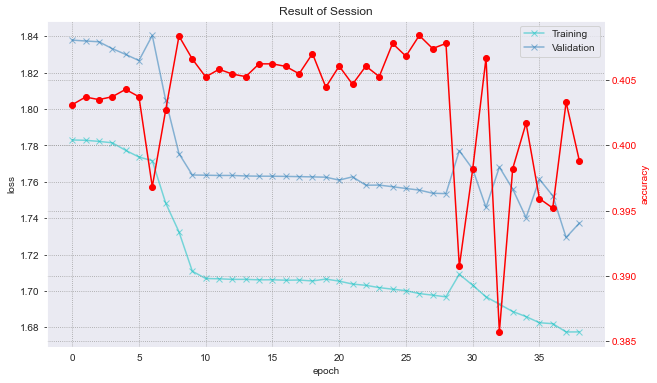

In [87]:
session_result()

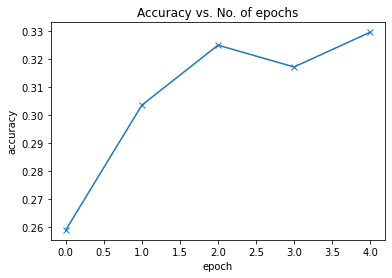

In [85]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [12]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 1.180417776107788, 'val_acc': 0.8042968511581421}

In [13]:
jovian.log_metrics(test_acc=result['val_acc'], test_loss=result['val_loss'])

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY:

## Prediction

In [16]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 2


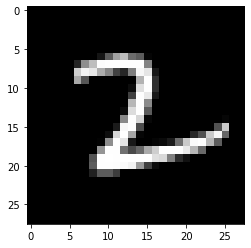

In [17]:
img, label = test_ds[919]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

## Save and upload

In [18]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [ ]:
jovian.commit(project='mnist-logistic-minimal', environment=None, outputs=['mnist-logistic.pth'])
jovian.commit(project='mnist-logistic-minimal', environment=None, outputs=['mnist-logistic.pth']) # Kaggle commit fails sometimes, so try again..

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
